<a href="https://colab.research.google.com/github/mrm8488/shared_colab_notebooks/blob/master/TF_emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Emotion classifier with Tensorflow 2

> Author: [Manuel Romero](https://twitter.com/mrm8488)

> Dataset and idea from: [Elvis](https://twitter.com/omarsar0)

In [0]:
!nvidia-smi

Mon May  4 16:51:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Download GloVe word embeddings
We will use it to create the embedding layer so we will not have to train it in the model

In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-05-04 16:51:07--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-05-04 16:51:08--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-05-04 16:51:08--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
!rm -rf glove.6B.50d.txt
!rm -rf glove.6B.200d.txt
!rm -rf glove.6B.300d.txt

## Download the dataset

In [0]:
!wget https://www.dropbox.com/s/607ptdakxuh5i4s/merged_training.pkl

--2020-05-04 16:58:03--  https://www.dropbox.com/s/607ptdakxuh5i4s/merged_training.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/607ptdakxuh5i4s/merged_training.pkl [following]
--2020-05-04 16:58:08--  https://www.dropbox.com/s/raw/607ptdakxuh5i4s/merged_training.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0cc5a32002f45f5701faaddaa6.dl.dropboxusercontent.com/cd/0/inline/A3GjNNXOhAy8HUwPlw90F3CvhhF9apvzFDQ2Jga08qiMFekb9escyFtvI6OpmF9w5VU97uwTDFge7Jkl6EdF9bunULxbl5bG3dhEYZauHJz7tFmL_6q6UKP5W-5xqZZjCvQ/file# [following]
--2020-05-04 16:58:08--  https://uc0cc5a32002f45f5701faaddaa6.dl.dropboxusercontent.com/cd/0/inline/A3GjNNXOhAy8HUwPlw90F3CvhhF9apvzFDQ2Jga08qiMFekb9escyFtvI6OpmF9w5VU97uwTDFge7Jkl6EdF9bunULxbl

In [0]:
import pickle

## helper function
def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

In [0]:
data = load_from_pickle(directory="merged_training.pkl")

## using a sample
emotions = [ "sadness", "joy", "love", "anger", "fear", "surprise"]
data= data[data["emotions"].isin(emotions)]

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416809 entries, 27383 to 64703
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      416809 non-null  object
 1   emotions  416809 non-null  object
dtypes: object(2)
memory usage: 9.5+ MB


In [0]:
data.describe()

,text,emotions
count,416809,416809
unique,393822,6
top,i feel more adventurous willing to take risks,joy
freq,16,141067


In [0]:
data.isna().sum()

text        0
emotions    0
dtype: int64

In [0]:
data.isnull().sum()

text        0
emotions    0
dtype: int64

In [0]:
data.head(20)

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love
18231,i find myself frustrated with christians becau...,love
10714,i am one of those people who feels like going ...,joy
35177,i feel especially pleased about this as this h...,joy
122177,i was struggling with these awful feelings and...,joy
26723,i feel so enraged but helpless at the same time,anger


In [0]:
data[0]

array([   1,  459,  264,   12, 1267, 4070, 1386,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

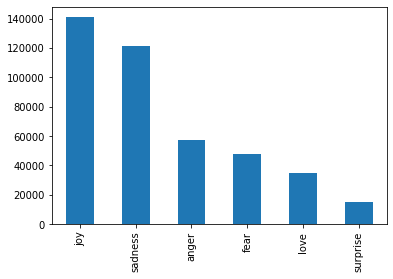

In [0]:
data.emotions.value_counts().plot.bar()

In [0]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 170 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)

train = data

#labels = emotions
y = train['emotions'].values
comments_train = train['text']
comments_train = list(comments_train)

In [0]:
y

array(['sadness', 'sadness', 'joy', ..., 'sadness', 'joy', 'sadness'],
      dtype=object)

In [0]:
len(comments_train)

416809

In [0]:
max_text = (max(comments_train, key=len))

In [0]:
len(max_text.split())

178

In [0]:
def num_words(sentence):
  words = sentence.split()
  return len(words)

In [0]:
total_avg_words = sum( map(num_words, comments_train) ) / len(comments_train)
total_avg_words

19.211015117235952

In [0]:
MAX_SEQUENCE_LENGTH = 50

## Text pre-proccessing

In [0]:
import re
from tqdm import tqdm_notebook

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
def clean_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'[^\w\s]','',text).lower()
    if remove_stopwords:
        text = text.split(" ")
        for word in text:
            if word not in stopwords.words("english"):
                output = output + " " + word
    else:
        output = text
    return str(output.strip())[1:-3].replace("  ", " ")

In [0]:
texts = [] 

for line in tqdm_notebook(comments_train, total=159571): 
    texts.append(clean_text(line))

In [0]:
len(texts)

416809

In [0]:
print('Sample data:', texts[1], y[1])

Sample data: m alone feel aw sadness


## Tokenize the texts

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [0]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 86474


In [0]:
import json
with open('word_index.json', 'w') as f:
    json.dump(word_index, f)
with open('index_word.json', 'w') as f2:
    json.dump(tokenizer.index_word, f2)

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (416809, 50)
Shape of label tensor: (416809,)


In [0]:
import numpy as np

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [0]:
data[25]

array([2562,  119,    3,   71,  120,  714,  602, 1546,  186,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [0]:
labels[25]

array([0, 1, 0, 0, 0, 0])

## One-hot encoding labels

In [0]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(labels)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [0]:
lb.classes_

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'], dtype='<U8')

In [0]:
labels = lb.transform(labels)

In [0]:
labels[25]

array([0, 1, 0, 0, 0, 0])

In [0]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [ 45948  38184 113044  27588  96741  11943]
validation:  [11369  9528 28023  6966 24446  3029]


In [0]:
x_train.shape

(333448, 50)

In [0]:
y_train.shape

(333448, 6)

In [0]:
x_val.shape

(83361, 50)

In [0]:
y_val.shape

(83361, 6)

## Create test set

In [0]:
x_val = x_val[: -40000]
y_val = y_val[: -40000]
x_test = x_val[-40000: ]
y_test = y_val[-40000: ]

In [0]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [ 433  917  120 1164 4537  215  171 2252    2 1865  496  136    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
One hot label: 
 [0 0 0 0 1 0]


## Create the embedding matrix for our model

In [0]:
embeddings_index = {}
f = open('/content/glove.6B.100d.txt')
print('Loading GloVe from:', '/content/glove.6B.100d.txt','...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: /content/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [0]:
embedding_matrix.shape

(86475, 100)

## Create the model (function API)

In [0]:
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [0]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="softmax")(x)

In [0]:
model = Model(sequence_input, preds)
model.compile(loss = 'categorical_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])

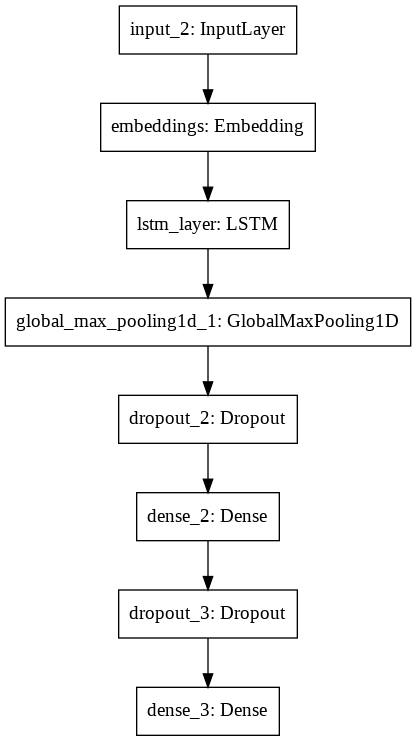

In [0]:
import tensorflow as tf
tf.keras.utils.plot_model(model)

In [0]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 5, batch_size=128, validation_data=(x_val, y_val))

Training progress:
Epoch 1/5
2606/2606 [==============================] - 16s 6ms/step - loss: 0.5899 - accuracy: 0.7805 - val_loss: 0.2674 - val_accuracy: 0.8910
Epoch 2/5
2606/2606 [==============================] - 15s 6ms/step - loss: 0.2450 - accuracy: 0.9001 - val_loss: 0.1784 - val_accuracy: 0.9136
Epoch 3/5
2606/2606 [==============================] - 15s 6ms/step - loss: 0.1852 - accuracy: 0.9156 - val_loss: 0.1560 - val_accuracy: 0.9189
Epoch 4/5
2606/2606 [==============================] - 15s 6ms/step - loss: 0.1593 - accuracy: 0.9211 - val_loss: 0.1423 - val_accuracy: 0.9227
Epoch 5/5
2606/2606 [==============================] - 15s 6ms/step - loss: 0.1450 - accuracy: 0.9238 - val_loss: 0.1426 - val_accuracy: 0.9214


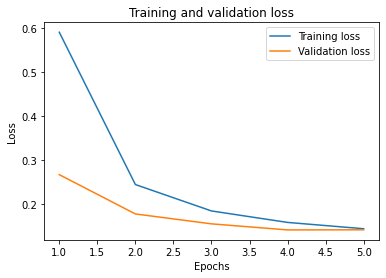

In [0]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

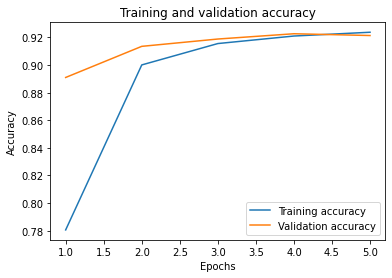

In [0]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [0]:
print("Accuracy in the test set:")
model.evaluate(x_test, y_test)[1]

## Test the model

In [0]:
samples = ['i feel like, i do not know...', 'love you woman', 'that is so funny', 'mamma, i just killed a man', 'i want to ride my bicycle', 'im alone i feel awful', 'i beleive that i am much more sensitive to oth...']

In [0]:
cleaned_samples = []
for sentence in samples:
  print(sentence)
  cleaned = clean_text(sentence)
  print(cleaned)
  cleaned_samples.append(cleaned)

i feel like, i do not know...
eel like k
love you woman
ove wo
that is so funny
u
mamma, i just killed a man
amma killed 
i want to ride my bicycle
ant ride bicy
im alone i feel awful
m alone feel aw
i beleive that i am much more sensitive to oth...
eleive much sensitive 


In [0]:
tokenized_seq = tokenizer.texts_to_sequences(cleaned_samples)
padded_seq =  pad_sequences(tokenized_seq, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

In [0]:
int2label = {
    0: 'anger',
    1: 'fear',
    2: 'joy',
    3: 'love',
    4: 'sadness',
    5: 'surprise'
}

In [0]:
predictions = model.predict(padded_seq)

In [0]:
for i, prediction in enumerate(predictions):
  print(samples[i] +" => " +int2label[(np.argmax(prediction))])

i feel like, i do not know... => joy
love you woman => anger
that is so funny => anger
mamma, i just killed a man => anger
i want to ride my bicycle => fear
im alone i feel awful => sadness
i beleive that i am much more sensitive to oth... => anger


In [0]:
model.save('model.h5')

In [0]:
!pip install -q tensorflowjs

     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 92kB 6.8MB/s 
     |████████████████████████████████| 104.6MB 118kB/s 
     |████████████████████████████████| 256kB 54.3MB/s 
     |████████████████████████████████| 921kB 56.9MB/s 
     |████████████████████████████████| 3.9MB 59.0MB/s 
     |████████████████████████████████| 450kB 50.2MB/s 
ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


## Convert the model to TFjs format, zip and download it

In [0]:
!tensorflowjs_converter --input_format=keras /content/model.h5 /content/tfjs_model

In [0]:
!zip -r tfjs_model /content/tfjs_model

  adding: content/tfjs_model/ (stored 0%)
  adding: content/tfjs_model/group1-shard7of9.bin (deflated 8%)
  adding: content/tfjs_model/group1-shard9of9.bin (deflated 8%)
  adding: content/tfjs_model/group1-shard4of9.bin (deflated 8%)
  adding: content/tfjs_model/model.json (deflated 76%)
  adding: content/tfjs_model/group1-shard2of9.bin (deflated 8%)
  adding: content/tfjs_model/group1-shard6of9.bin (deflated 8%)
  adding: content/tfjs_model/group1-shard5of9.bin (deflated 8%)
  adding: content/tfjs_model/group1-shard1of9.bin (deflated 8%)
  adding: content/tfjs_model/group1-shard3of9.bin (deflated 8%)
  adding: content/tfjs_model/group1-shard8of9.bin (deflated 8%)


In [0]:
from google.colab import files
files.download('/content/tfjs_model.zip')